# Example 3

This short example will show the user how to calculate the high frequency decay parameter (κ) from a single (processed) ground motion. Then, using this ground motion, calculate a Scale Factor for low-strain damping ($D_{min}$) for the Darendeli Model to achieve a target value of delta_kappa.  The target delta kappa is the empirical value derived from the surface and base motion kappa values.

### Step 0: Import ground motion data

In this case, two MSEED files for a small-strain ground motion are to be analyzed. This example includes the processed base and surface motions from an event recorded at the Kik-Net site *TCGH16*.

In [1]:
from datools import site_response_small, scale_factors, signal_processing
import matplotlib.pyplot as plt

base_motion = signal_processing.genstream("data/Example_3/base","MSEED")
surface_motion = signal_processing.genstream("data/Example_3/surface","MSEED")



Total traces combined: 1
Total traces combined: 1


### Step 1: Plot Fourier Amplitude Spectra

At high frequencies the Fourier spectrum of S-waves exhibits exponential decay ([Anderson & Hough 1984](https://authors.library.caltech.edu/records/5wc93-4px51)):  

$$
(e^{-πκf})
$$

Where κ is the spectral decay parameter.  
  
  If one plots the fourier amplitude spectrum (FAS) in linear-log scale, κ is essentially the slope of the decay. However, it is necessary to manually set a frequency range that characterizes this decay and is used to compute the slope and κ. To do this, the FAS (calculated via a FFT) needs to be obtained.  

  It can be difficult to interpret a raw FAS (left Figure). A way to make the data more readable is to apply the Konno-Ohmachi smoothing filter function (right Figure). The Konno-Ohmachi bandwidth (parameter b) controls the intensity of the smoothing function; a smaller bandwidth smooths the data to a greater degree than a larger number. In this case, I am using a bandwidth of 40.




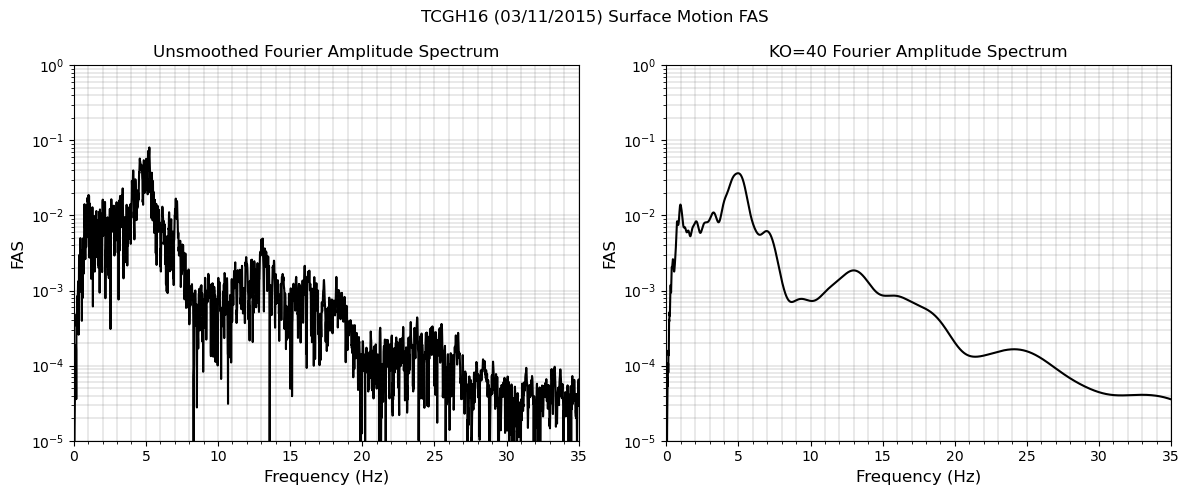

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12, 5))
scale_factors.plot_FAS(surface_motion[0],ax[0]) #plot_FAS is a user-defined function that both computes and plots the FAS
scale_factors.plot_FAS(surface_motion[0],ax[1],ko=40)

for a in ax:
    a.set_xlim(0, 35)
    a.set_ylim(.00001, 1)

ax[0].set_title('Unsmoothed Fourier Amplitude Spectrum')
ax[1].set_title('KO=40 Fourier Amplitude Spectrum')

plt.suptitle('TCGH16 (03/11/2015) Surface Motion FAS')
plt.tight_layout()

### Step 2: Calculate the Kappa Values for Base and Surface Motions

The previous plot emphasizes the difficulty in manually selecting the frequency bounds in which to calculate κ.  
  
  For this example, the slope (that once again, represents κ) will be computed from frequencies 12Hz - 25Hz. The following function (*calculate_kappa_and_plot*) allows the user to input a selected frequency range and calculate the κ-value. As discussed above, smoothing the FAS via the Konno-Ohmachi procedure increases readability.

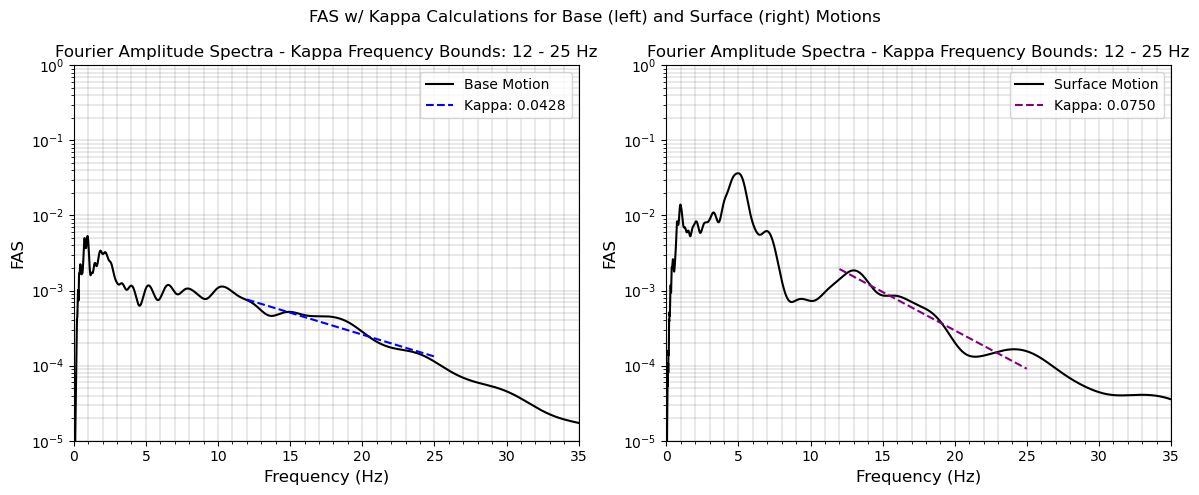

In [3]:
fig, ax = plt.subplots(1,2, figsize=(12, 5))

#initializing dictionaries to store kappa values
kappa_values_base =[]
kappa_values_surface = []

#frequency bounds:
low=12 #Hz
high=25 #Hz

for trace in base_motion:
    kappa = scale_factors.calculate_kappa_and_plot(trace,ax[0],color='black', label='Base Motion', color_2='blue',
                                    low_freq=low,high_freq=high)
    filename = trace.stats.filename
    if kappa is not None:
        kappa_values_base.append((kappa, filename))

for trace in surface_motion:
    kappa = scale_factors.calculate_kappa_and_plot(trace,ax[1],color='black', label='Surface Motion', color_2='purple',
                                    low_freq=low,high_freq=high)
    filename = trace.stats.filename
    if kappa is not None:
        kappa_values_surface.append((kappa, filename))


for a in ax:
    a.set_xlim(0, 35)
    a.set_ylim(.00001, 1)
    a.legend()

plt.suptitle('FAS w/ Kappa Calculations for Base (left) and Surface (right) Motions')
plt.tight_layout()

### Step 2.1: Normalizing the Fourier Amplitude Spectra

Sometimes normalizing the FAS by its Amplitude at a given frequency is useful for comparing multiple FAS plots. For example, the plots below represent the same motions as above, but they are normalized by the FAS at 3Hz.  The plots below will look the same as their unnormalized counterparts, but they will have a standardized amplitude.

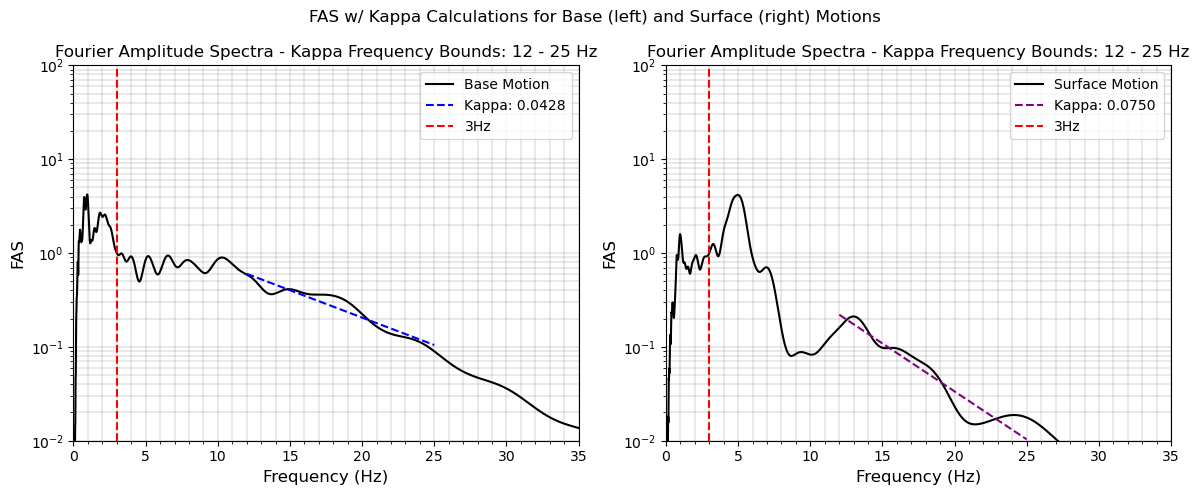

In [4]:
fig, ax = plt.subplots(1,2, figsize=(12, 5))

for trace in base_motion:
    kappa = scale_factors.calculate_kappa_and_plot(trace,ax[0],norm_freq=3,color='black', label='Base Motion', color_2='blue',
                                    low_freq=low,high_freq=high)

for trace in surface_motion:
    kappa = scale_factors.calculate_kappa_and_plot(trace,ax[1],norm_freq=3,color='black', label='Surface Motion', color_2='purple',
                                    low_freq=low,high_freq=high)

for a in ax:
    a.set_xlim(0, 35)
    a.set_ylim(.01, 100)
    a.legend()

plt.suptitle('FAS w/ Kappa Calculations for Base (left) and Surface (right) Motions')
plt.tight_layout()

### Step 3: Consolidating Calculated Kappa Data into DataFrame

The difference between kappa at the surface and kappa at the base is termed delta kappa:
$$
\Deltaκ = κ_{surface} - κ_{base}
$$

$\Delta$κ conveys the soil's affect on high frequency decay during wave propagation. It is an important value in calculating the Darendeli $D_{min}$ scale factor. The function below consolidates the kappa values that were calculated for the accompanying base and surface motions into a Pandas DataFrame and also calculated $\Delta$κ.

In [5]:
kappa_df = scale_factors.generate_kappa_df(kappa_values_base,kappa_values_surface,drop_na=False)
kappa_df.head()

,BaseFilename,EW1,EW2,EW_delta
0,TCGH160311150344,0.042788,0.07496,0.032172


### Step 4: Calculating $D_{min}$ Scale Factor

κ can be related to the soil's damping and shear wave velocity:

$$
κ  \propto \int_{\text{travel path}} \frac{2D}{V_s} \, dz
$$

Discretizing by soil layer:
$$
κ \propto \sum_{i=1}^{n} \frac{2H_i{D_{min}}_{i}(SF)}{{V_s}_i}
$$

Or more explicitly:
$$
κ_{surface} = κ_{base} + \sum_{i=1}^{n} \frac{2H_i{D_{min}}_{i}(SF)}{{V_s}_i}
$$

Where:

$$
\Deltaκ = κ_{surface} - κ_{base}
$$

And:

$$
\Deltaκ = \sum_{i=1}^{n} \frac{2H_i{D_{min}}_{i}(SF)}{{V_s}_i}
$$

Since κ_{surface}, κ_{base}, D_{min} (Darendeli), and V_{s} are known, it is possible to solve for the Scale Factor SF.




In [7]:
#### Generating the Site Profile for TCGH16
site_data = site_response_small.parse_site_data('data/Example_2/site_data.txt')
profile_df=site_data['TCGH16'].copy()
profile_df['damping_min'] = profile_df.apply(scale_factors.calc_damp_min, axis=1)

#Parameters needed to calculate scale factor
vs = profile_df['Vs']
dmin = profile_df['damping_min']
h = profile_df['Thickness']
kappa_delta = kappa_df['EW_delta']

#Dmin Scale Factor
sf = scale_factors.calculate_sf(vs,h,dmin,kappa_delta)

print(f"Data for TCGH16:")
print(profile_df.head())

print(f"κ Scale Factor:")
print(f"\033[1m{sf.iloc[0]}\033[0m")

Data for TCGH16:
   Layer     Vs  Mean_Stress  OCR    PI  Unit_Weight  Thickness  damping_min
0      1   80.0        26.67  1.0  10.0         20.0        4.0     0.014141
1      2  160.0        66.92  1.0  10.0         20.0        4.0     0.010821
2      3  280.0       114.47  1.0  10.0         20.0       10.0     0.009258
3      4  400.0       250.34  1.0  10.0         20.0       30.0     0.007374
4      5  450.0       447.35  1.0  10.0         20.0       28.0     0.006230
κ Scale Factor:
6.234753078150051
